<a href="https://colab.research.google.com/github/shoboske/wine-quality-deep-learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install ucimlrepo scikit-learn pandas numpy matplotlib tensorflow >/dev/null 2>&1

In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


# fetch dataset
wine_quality = fetch_ucirepo(id=186)
red_wine = wine_quality.data.original.query('color == "red"')
white_wine = wine_quality.data.original.query('color == "white"')

columns_to_drop = ['quality', 'color']

# print(wine_quality.data.features)
num_classes = 11
X_red = red_wine.drop(columns=columns_to_drop)
y_red = tf.keras.utils.to_categorical(red_wine['quality'], num_classes=num_classes)

X_white = white_wine.drop(columns=columns_to_drop)
y_white = tf.keras.utils.to_categorical(white_wine['quality'], num_classes=num_classes)


In [47]:
import matplotlib.pyplot as plt
def plot_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def std_deviation_score(X, y=None):
    return np.std(X, axis=0)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import concurrent.futures
import tensorflow as tf
from imblearn.over_sampling import SMOTE

# Split data into training and testing sets
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.09, random_state=42)
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.09, random_state=42)

# Create a Pipeline for feature selection and scaling
# Define the pipeline steps
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('selector', SelectKBest(score_func=std_deviation_score, k=8)),
    ('pca', PCA(n_components=6))
])

# Fit and transform the pipeline on the training data (for both red and white wine)
X_red_train_processed = pipeline.fit_transform(X_red_train, y_red_train)
X_white_train_processed = pipeline.fit_transform(X_white_train, y_white_train)

# Transform the test data (for both red and white wine)
X_red_test_processed = pipeline.transform(X_red_test)
X_white_test_processed = pipeline.transform(X_white_test)

36/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4512 - loss: 1.2815 - mse: 0.0612

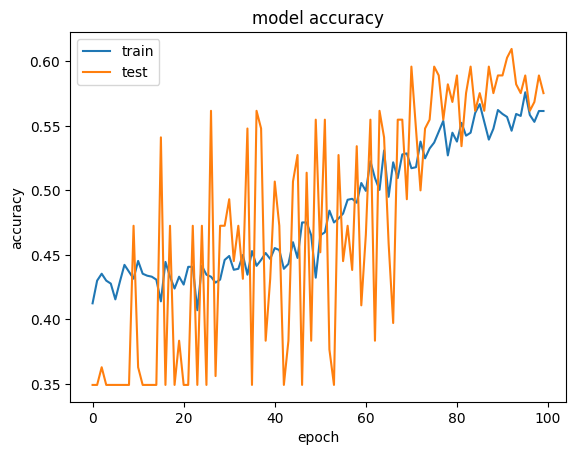

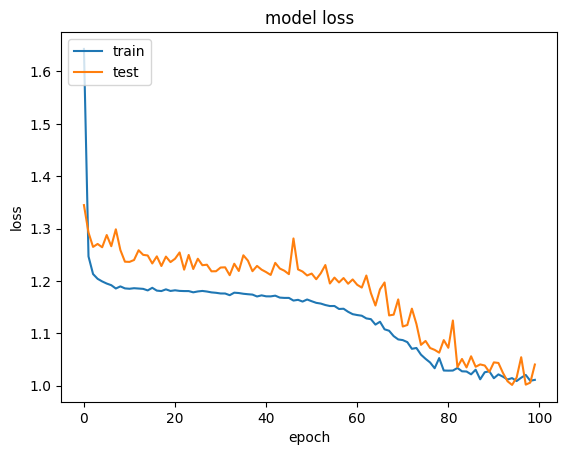

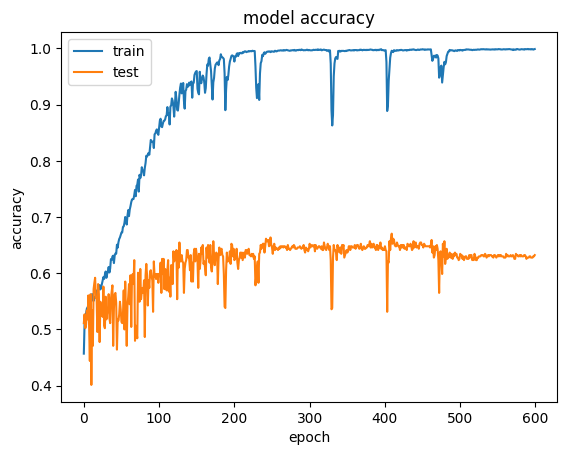

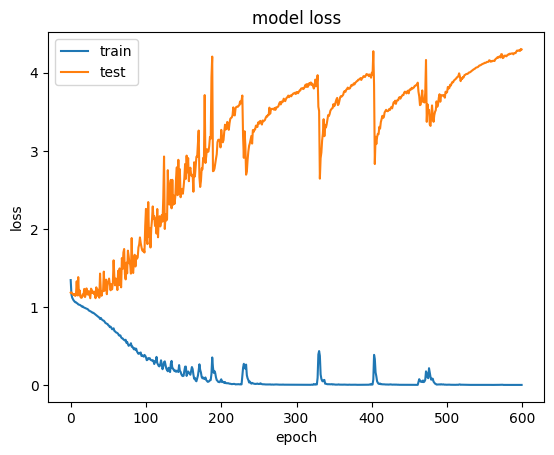

In [85]:

# Red Wine Model
red_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_red_train_processed.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='sigmoid'),
        tf.keras.layers.Dense(80, activation='sigmoid'),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.Dense(80, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ],
     name="red-wine"
)

# White Wine Model (similar structure, adjust input shape)
white_wine_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_white_train_processed.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ],
    name="white-wine"
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min')
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='loss',  # Metric to monitor (e.g., validation loss)
#     factor=0.5,          # Factor to reduce learning rate by (e.g., reduce by half)
#     patience=5,          # Number of epochs with no improvement before reducing
#     min_lr=0.001      # Minimum learning rate allowed
# )

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

optimizer_red = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_white = tf.keras.optimizers.SGD(learning_rate=0.01)

# Compile models (choose appropriate optimizer, loss, metrics)
red_wine_model.compile(optimizer=optimizer_red, loss=loss_fn, metrics=['accuracy'])
white_wine_model.compile(optimizer=optimizer_white, loss=loss_fn, metrics=['accuracy', 'mse'])

# Train the models
def train_model(model, X_train, y_train, **kwargs):
    return model.fit(X_train, y_train, **kwargs)

# Train the models concurrently using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the training tasks for both models
    red_wine_future = executor.submit(train_model, red_wine_model,
                                      X_red_train_processed, y_red_train,
                                      batch_size=32, epochs=100,
                                      validation_split=0.1, validation_freq=1,
                                      callbacks=[callback], verbose=0)
    # white_wine_future = executor.submit(train_model,
    #                                     white_wine_model,
    #                                     X_white_train_processed,
    #                                     y_white_train, batch_size=32,
    #                                     epochs=600, validation_split=0.1,
    #                                     validation_freq=1,
    #                                     callbacks=[callback], verbose=0)

    # Get the results (history objects)
    red_wine_history = red_wine_future.result()
    # white_wine_history = white_wine_future.result()

plot_graph(red_wine_history)
plot_graph(white_wine_history)

In [83]:
# Evaluate the model (you can use various metrics like accuracy, precision, recall, etc.)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# Predictions for red and white wine
y_red_wine_pred = red_wine_model.predict(X_red_test_processed)  # Predictions for red wine
y_white_wine_pred = white_wine_model.predict(X_white_test_processed) # Predictions for white wine

# Convert predictions to class labels (if necessary)
y_red_wine_pred_classes = np.argmax(y_red_wine_pred, axis=1)
y_white_wine_pred_classes = np.argmax(y_white_wine_pred, axis=1)

# Convert y_red_test to multiclass format to match y_red_wine_pred_classes
y_red_test_classes = np.argmax(y_red_test, axis=1)
# Convert y_white_test to multiclass format to match y_white_wine_pred_classes
y_white_test_classes = np.argmax(y_white_test, axis=1)


# Evaluate Red Wine Model
accuracy_red = accuracy_score(y_red_test_classes, y_red_wine_pred_classes)
recall_red = recall_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted')
precision_red = precision_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted', zero_division=0.0)
f1_red = f1_score(y_red_test_classes, y_red_wine_pred_classes, average='weighted')

# Evaluate White Wine Model
accuracy_white = accuracy_score(y_white_test_classes, y_white_wine_pred_classes)
recall_white = recall_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted')
precision_white = precision_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted', zero_division=0.0)
f1_white = f1_score(y_white_test_classes, y_white_wine_pred_classes, average='weighted')

# Create data for DataFrame
data = [
    [f"{red_wine_model.name} ({', '.join(map(str, [*red_wine_model.layers[0].input.shape[1:], *[layer.units for layer in red_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_red, recall_red, precision_red, f1_red],
    [f"{white_wine_model.name} ({', '.join(map(str, [*white_wine_model.layers[0].input.shape[1:], *[layer.units for layer in white_wine_model.layers if isinstance(layer, tf.keras.layers.Dense)]]))})", accuracy_white, recall_white, precision_white, f1_white]
]

headers = ["Model", "Accuracy", "Recall", "Precision", "F1 Score"]

# print(red_wine_model.summary())
# print(white_wine_model.summary())

print(pd.DataFrame(data, None, headers))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                                    Model  Accuracy    Recall  Precision  \
0  red-wine (6, 100, 100, 80, 80, 80, 11)  0.375000  0.375000   0.437924   
1  white-wine (6, 128, 128, 128, 128, 11)  0.052154  0.052154   0.083124   

   F1 Score  
0  0.385829  
1  0.042163  


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
